In [1]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns
from wishpy.dataworker import DataWorker
dw = DataWorker(google_secret='../../../wishpy/client_secret.json')
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/wishpy/dataworker.py:83: UserWarning: [Errno 2] No such file or directory: '../../../wishpy/client_secret.json'
  warnings.warn(str(e))


## Data Preparing

In [2]:
df = dw.td_query('''
SELECT 
--       delivery_program,
--       shipping_country,
--       td_time_format(ts_released_from_t,'yyyy-MM-dd','America/Los_Angeles') as release_date,
--       ts_wp_order_creation_from_t,
--       ts_fm_wp_order_creation_from_w,
--       ts_tracking_created_from_t,
--       ts_fm_track_created_from_w,
--       ts_marked_shipped_from_t,
--       ts_confirmed_shipped_from_t,
--       ts_fm_carrier_pickup_from_w,
--       ts_fm_arrive_first_mile_from_w,
--       ts_fm_arrive_epc_warehouse_from_w,
--       ts_lm_combine_complete_from_w,
--       ts_lm_track_created_from_w,
--       ts_lm_depart_epc_warehouse_from_w,
       
--       round((ts_tracking_created_from_t - ts_fm_track_created_from_w)/3600.00 , 2) as delta_tracking_created_hr,
       
--       round((ts_fm_arrive_epc_warehouse_from_w - ts_released_from_t)/3600.00 , 2)as fm_ttd_hr,
--       round((ts_fm_carrier_pickup_from_w - ts_released_from_t)/3600.00 , 2)as fm_release_to_pickup_ttd_hr,
--       round((ts_fm_track_created_from_w - ts_released_from_t)/3600.00 , 2)as fm_release_track_ttd_hr,
--       round((ts_fm_carrier_pickup_from_w - ts_fm_track_created_from_w)/3600.00 , 2)as fm_track_pickup_ttd_hr,
--       round((ts_fm_arrive_epc_warehouse_from_w - ts_fm_carrier_pickup_from_w)/3600.00 , 2)as fm_pickup_warehouse_ttd_hr,
       
       
--       round((ts_lm_depart_epc_warehouse_from_w - ts_fm_arrive_epc_warehouse_from_w)/3600.00 , 2) as warehouse_ttd_hr,
--       round((ts_lm_track_created_from_w - ts_fm_arrive_epc_warehouse_from_w)/3600.00 , 2) as warehouse_track_ttd_hr,
--       round((ts_lm_combine_complete_from_w - ts_lm_track_created_from_w)/3600.00 , 2) as warehouse_track_combine_ttd_hr,
--       round((ts_lm_depart_epc_warehouse_from_w - ts_lm_combine_complete_from_w)/3600.00 , 2) as warehouse_combine_depart_ttd_hr
         round((if(ts_FM_carrier_delivery_from_w>0,ts_FM_carrier_delivery_from_w,NULL) - if(ts_fm_carrier_pickup_from_w>0,ts_fm_carrier_pickup_from_w,NULL))/86400.00 , 2) as pickup_warehouse_ttd_day
       
from sweeper_dev.fm_warehouse_base
where TD_TIME_RANGE(ts_released_from_t, '2019-10-01 00:00:00', '2020-03-15 00:00:00', 'America/Los_Angeles')
'''
                #,job_id=688354315
                #,job_id=706189415
                )

You can look at job id 706189415


In [3]:
df.tail(5)
#pd.to_datetime(1578043897,unit='s')

,pickup_warehouse_ttd_day
81702623,NaN
81702624,NaN
81702625,NaN
81702626,NaN
81702627,NaN


## Overview of FM and warehouse TTD distribution

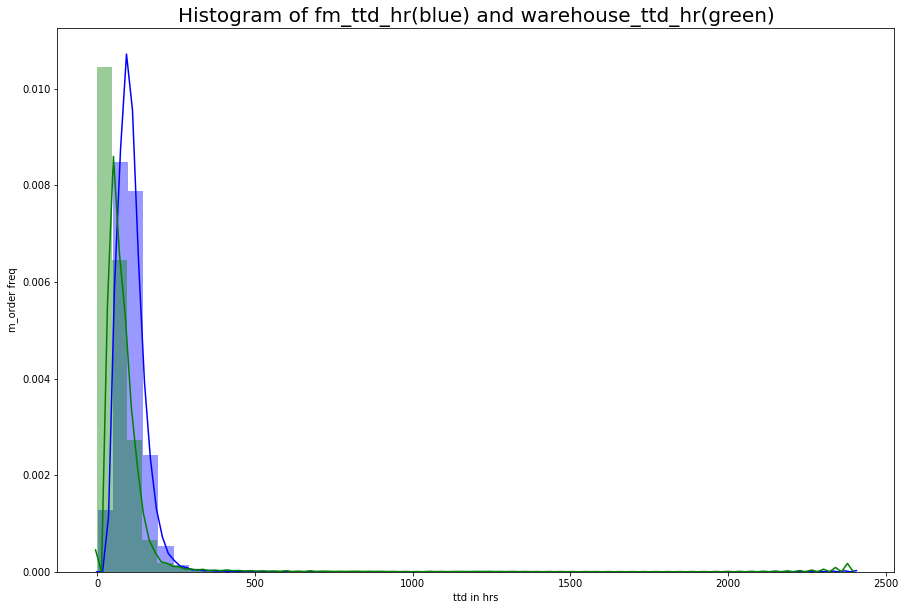

In [4]:
# seaborn histogram
plt.figure(figsize=(15,10))
sns.distplot(df.loc[pd.notnull(df.fm_ttd_hr),'fm_ttd_hr'], 
             hist=True, kde=True, 
             bins=50, color = 'blue')
sns.distplot(df.loc[pd.notnull(df.warehouse_ttd_hr),'warehouse_ttd_hr'], 
             hist=True, kde=True, 
             bins=50, color = 'green')
# adding labels and title
plt.title('Histogram of fm_ttd_hr(blue) and warehouse_ttd_hr(green)',size = 20)
plt.xlabel('ttd in hrs')
plt.ylabel('m_order freq')
plt.show()

## FM and warehouse Breakdown TTD 

In [19]:
mask1 = pd.notna(df.pickup_warehouse_ttd_day)
mask2 = df.pickup_warehouse_ttd_day <= 72/24.0
mask3 = df.pickup_warehouse_ttd_day <= 96/24.0
mask4 = df.pickup_warehouse_ttd_day <= 120/24.0
round(100*len(df[mask1 & mask2])/len(df[mask1]),2),round(100*len(df[mask1 & mask3])/len(df[mask1]),2),round(100*len(df[mask1 & mask4])/len(df[mask1]),2)

(85.03, 92.73, 95.33)

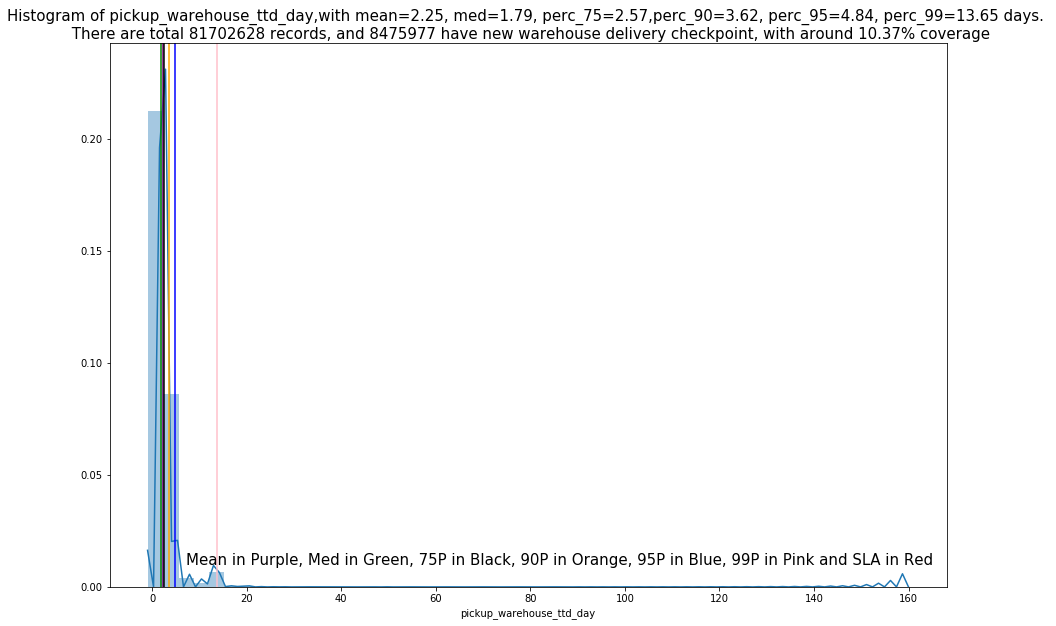

In [14]:
# checkpoint_list = ['delta_tracking_created_hr','fm_ttd_hr','fm_release_to_pickup_ttd_hr','fm_release_track_ttd_hr','fm_track_pickup_ttd_hr','fm_pickup_warehouse_ttd_hr',
#              'warehouse_ttd_hr','warehouse_track_ttd_hr','warehouse_track_combine_ttd_hr','warehouse_combine_depart_ttd_hr']

checkpoint_liszt = ['pickup_warehouse_ttd_day']

for cp in checkpoint_list:
    avg = round(df.loc[df[cp].notnull(),cp].mean(),2)
    perc_50 = round(df.loc[df[cp].notnull(),cp].median(),2)
    perc_75= round(df.loc[df[cp].notnull(),cp].quantile(0.75),2)
    perc_90= round(df.loc[df[cp].notnull(),cp].quantile(0.90),2)
    perc_95= round(df.loc[df[cp].notnull(),cp].quantile(0.95),2)
    perc_99= round(df.loc[df[cp].notnull(),cp].quantile(0.99),2)
    total_obs= len(df)
    new_cp_obs = len(df[pd.notna(df.pickup_warehouse_ttd_day)])
    coverage = round(100*new_cp_obs/total_obs,2)
    
    plt.figure(figsize=(15,10))
#    sns.set(rc={'figure.figsize':(12,10)})
    sns.distplot(df.loc[df[cp].notnull(),cp], hist=True, kde=True, bins=50)
    
    plt.title('Histogram of %s,with mean=%s, med=%s, perc_75=%s,perc_90=%s, perc_95=%s, perc_99=%s days. \n There are total %s records, and %s have new warehouse delivery checkpoint, with around %s%% coverage' %(cp,avg,perc_50,perc_75,perc_90,perc_95,perc_99,total_obs,new_cp_obs,coverage), size = 15)
    plt.axvline(avg, 0, 1, color='purple')
    plt.axvline(perc_50, 0, 1, color='green')
    plt.axvline(perc_75, 0, 1,color='black')
    plt.axvline(perc_90, 0, 1, color='orange')
    plt.axvline(perc_95, 0, 1, color='blue')
    plt.axvline(perc_99, 0, 1, color='pink')
    if cp in ['fm_ttd_hr','warehouse_ttd_hr']:
        plt.axvline(7*24, 0, 1, color='red')
    plt.text(perc_90*2,0.010,'Mean in Purple, Med in Green, 75P in Black, 90P in Orange, 95P in Blue, 99P in Pink and SLA in Red',size=15)
    plt.show()

## Further TTD breakdown by delivery program

In [7]:
checkpoint_list = ['fm_ttd_hr','fm_release_track_ttd_hr','fm_track_pickup_ttd_hr','fm_pickup_warehouse_ttd_hr',
             'warehouse_ttd_hr','warehouse_track_ttd_hr','warehouse_track_combine_ttd_hr','warehouse_combine_depart_ttd_hr']

delivery_list = ['A+','EPC','Fusion']

l = len(checkpoint_list)

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Delivery program is A+
----------------------------------------------------------------------------------------------------------------------------------------------------------------


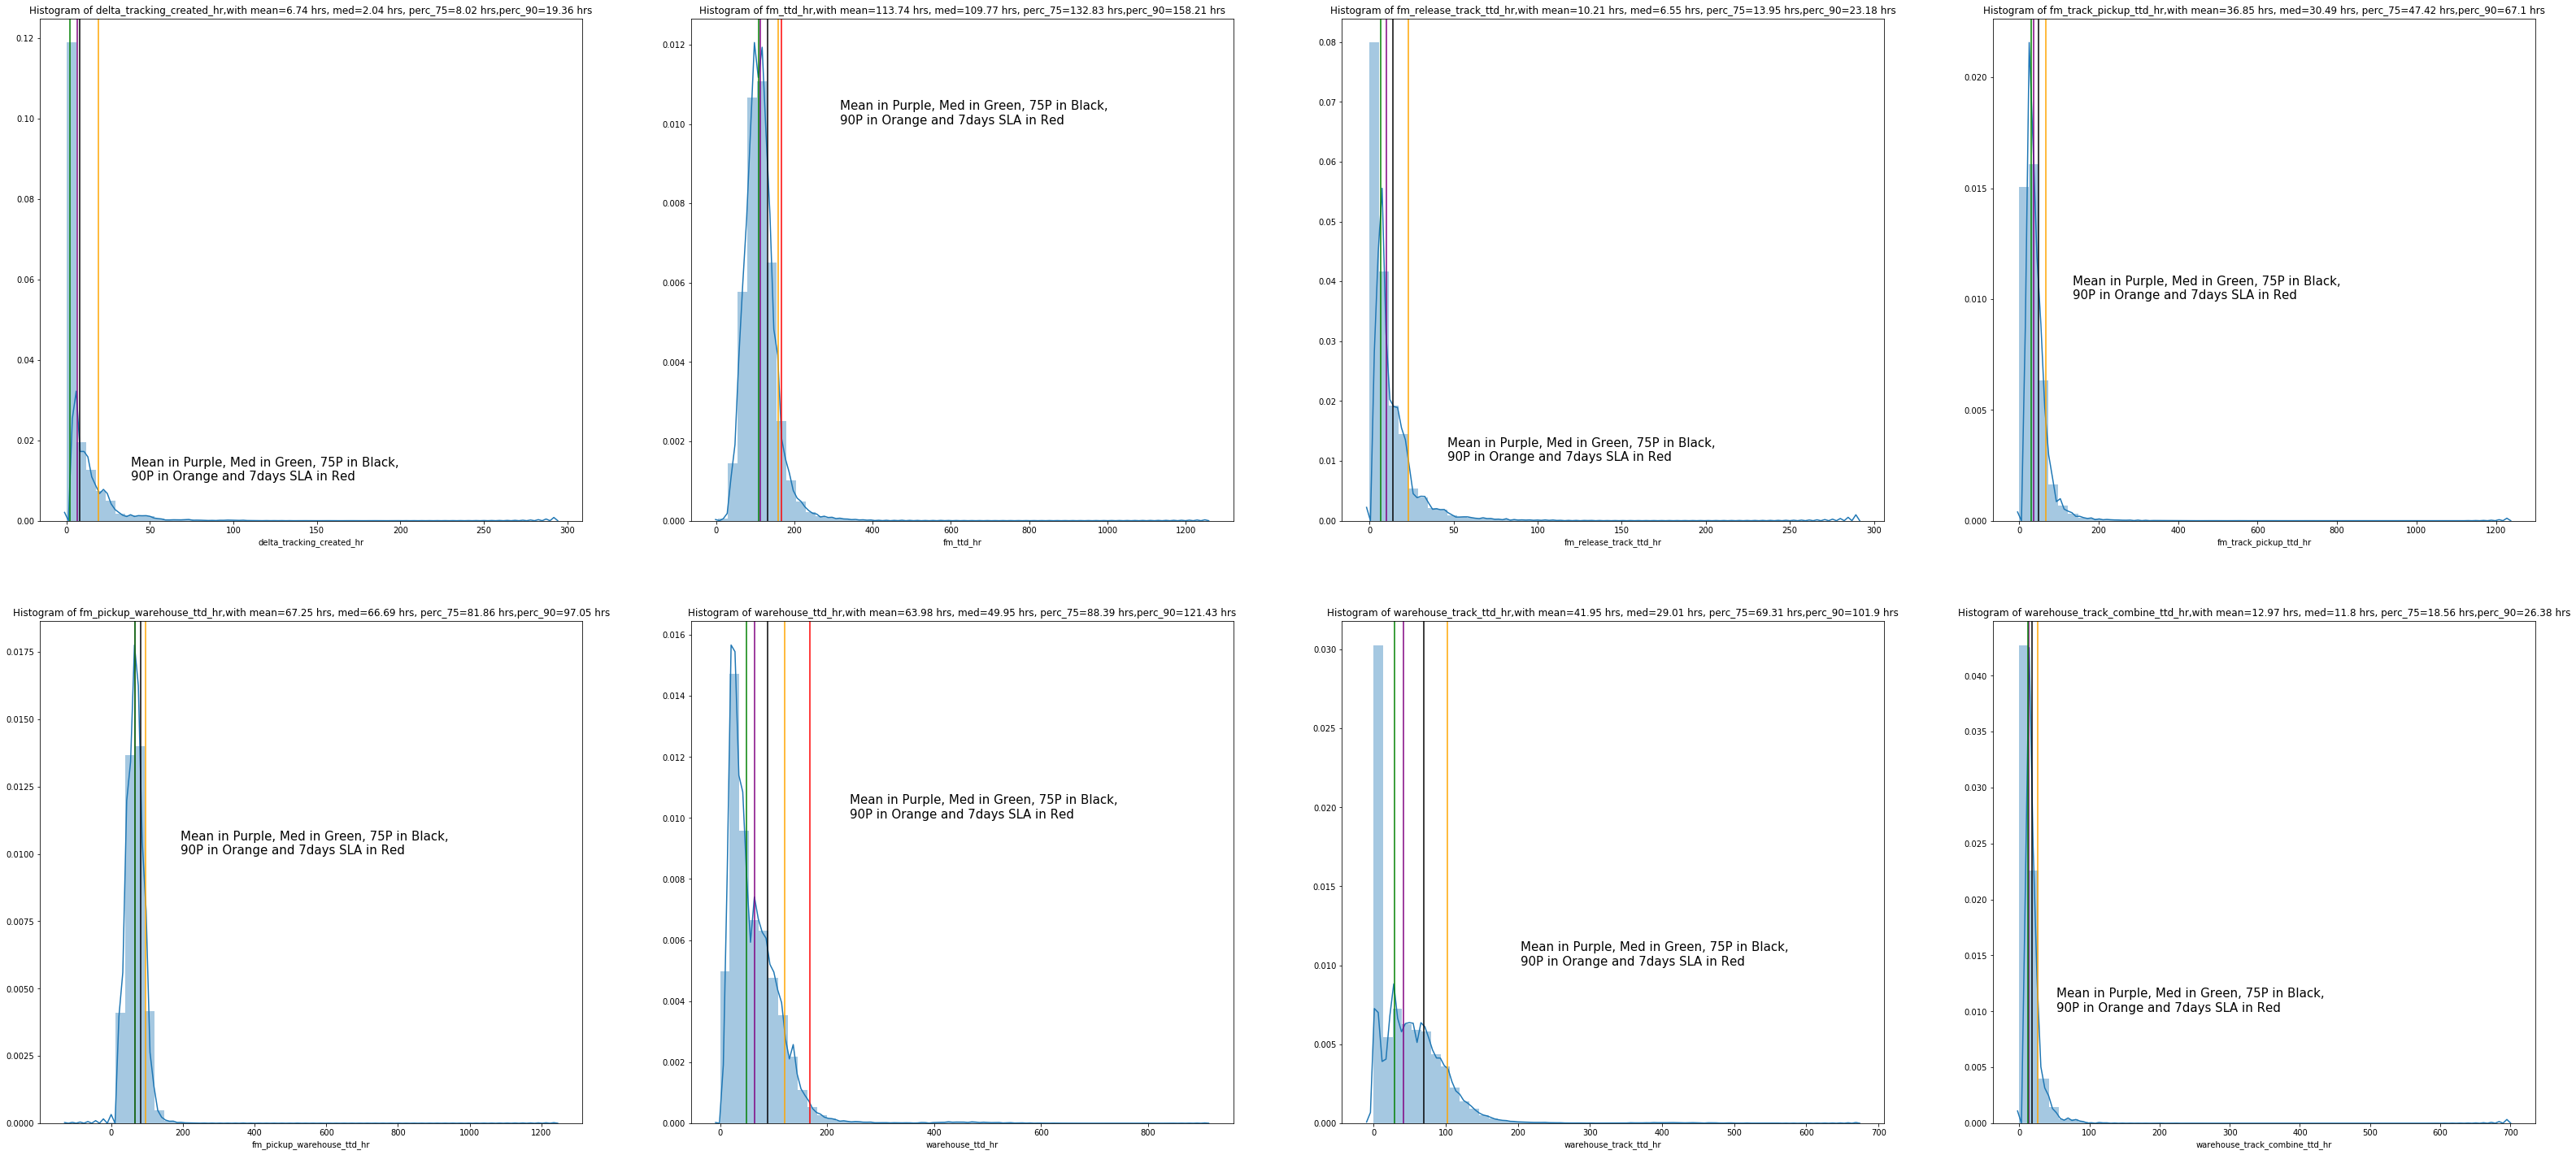

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Delivery program is EPC
----------------------------------------------------------------------------------------------------------------------------------------------------------------


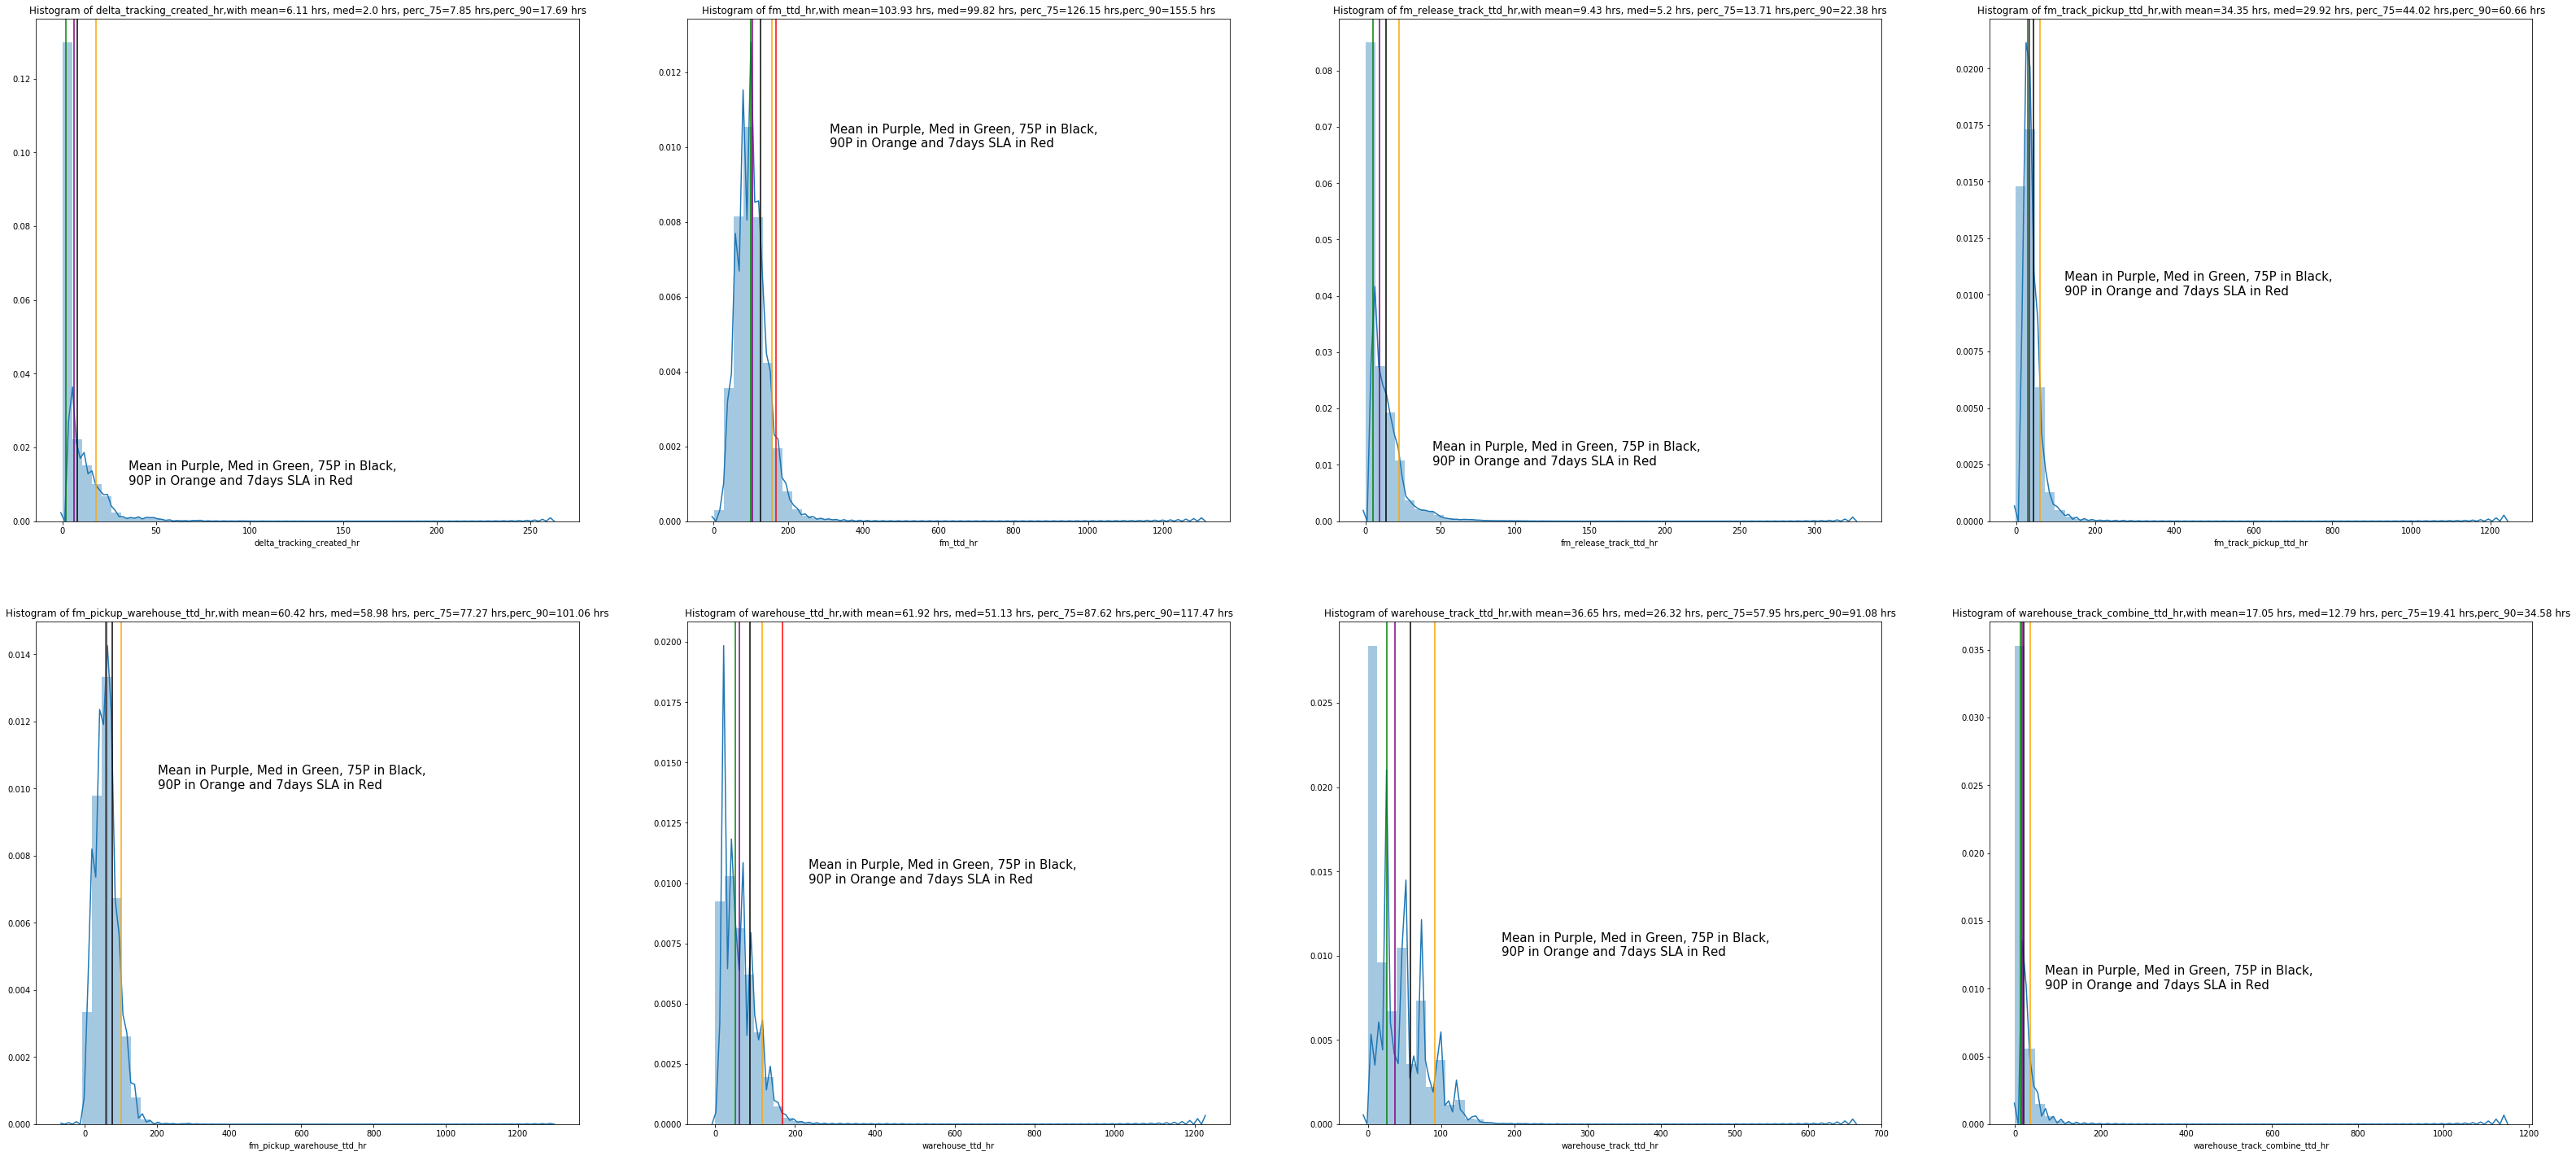

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Delivery program is Fusion
----------------------------------------------------------------------------------------------------------------------------------------------------------------


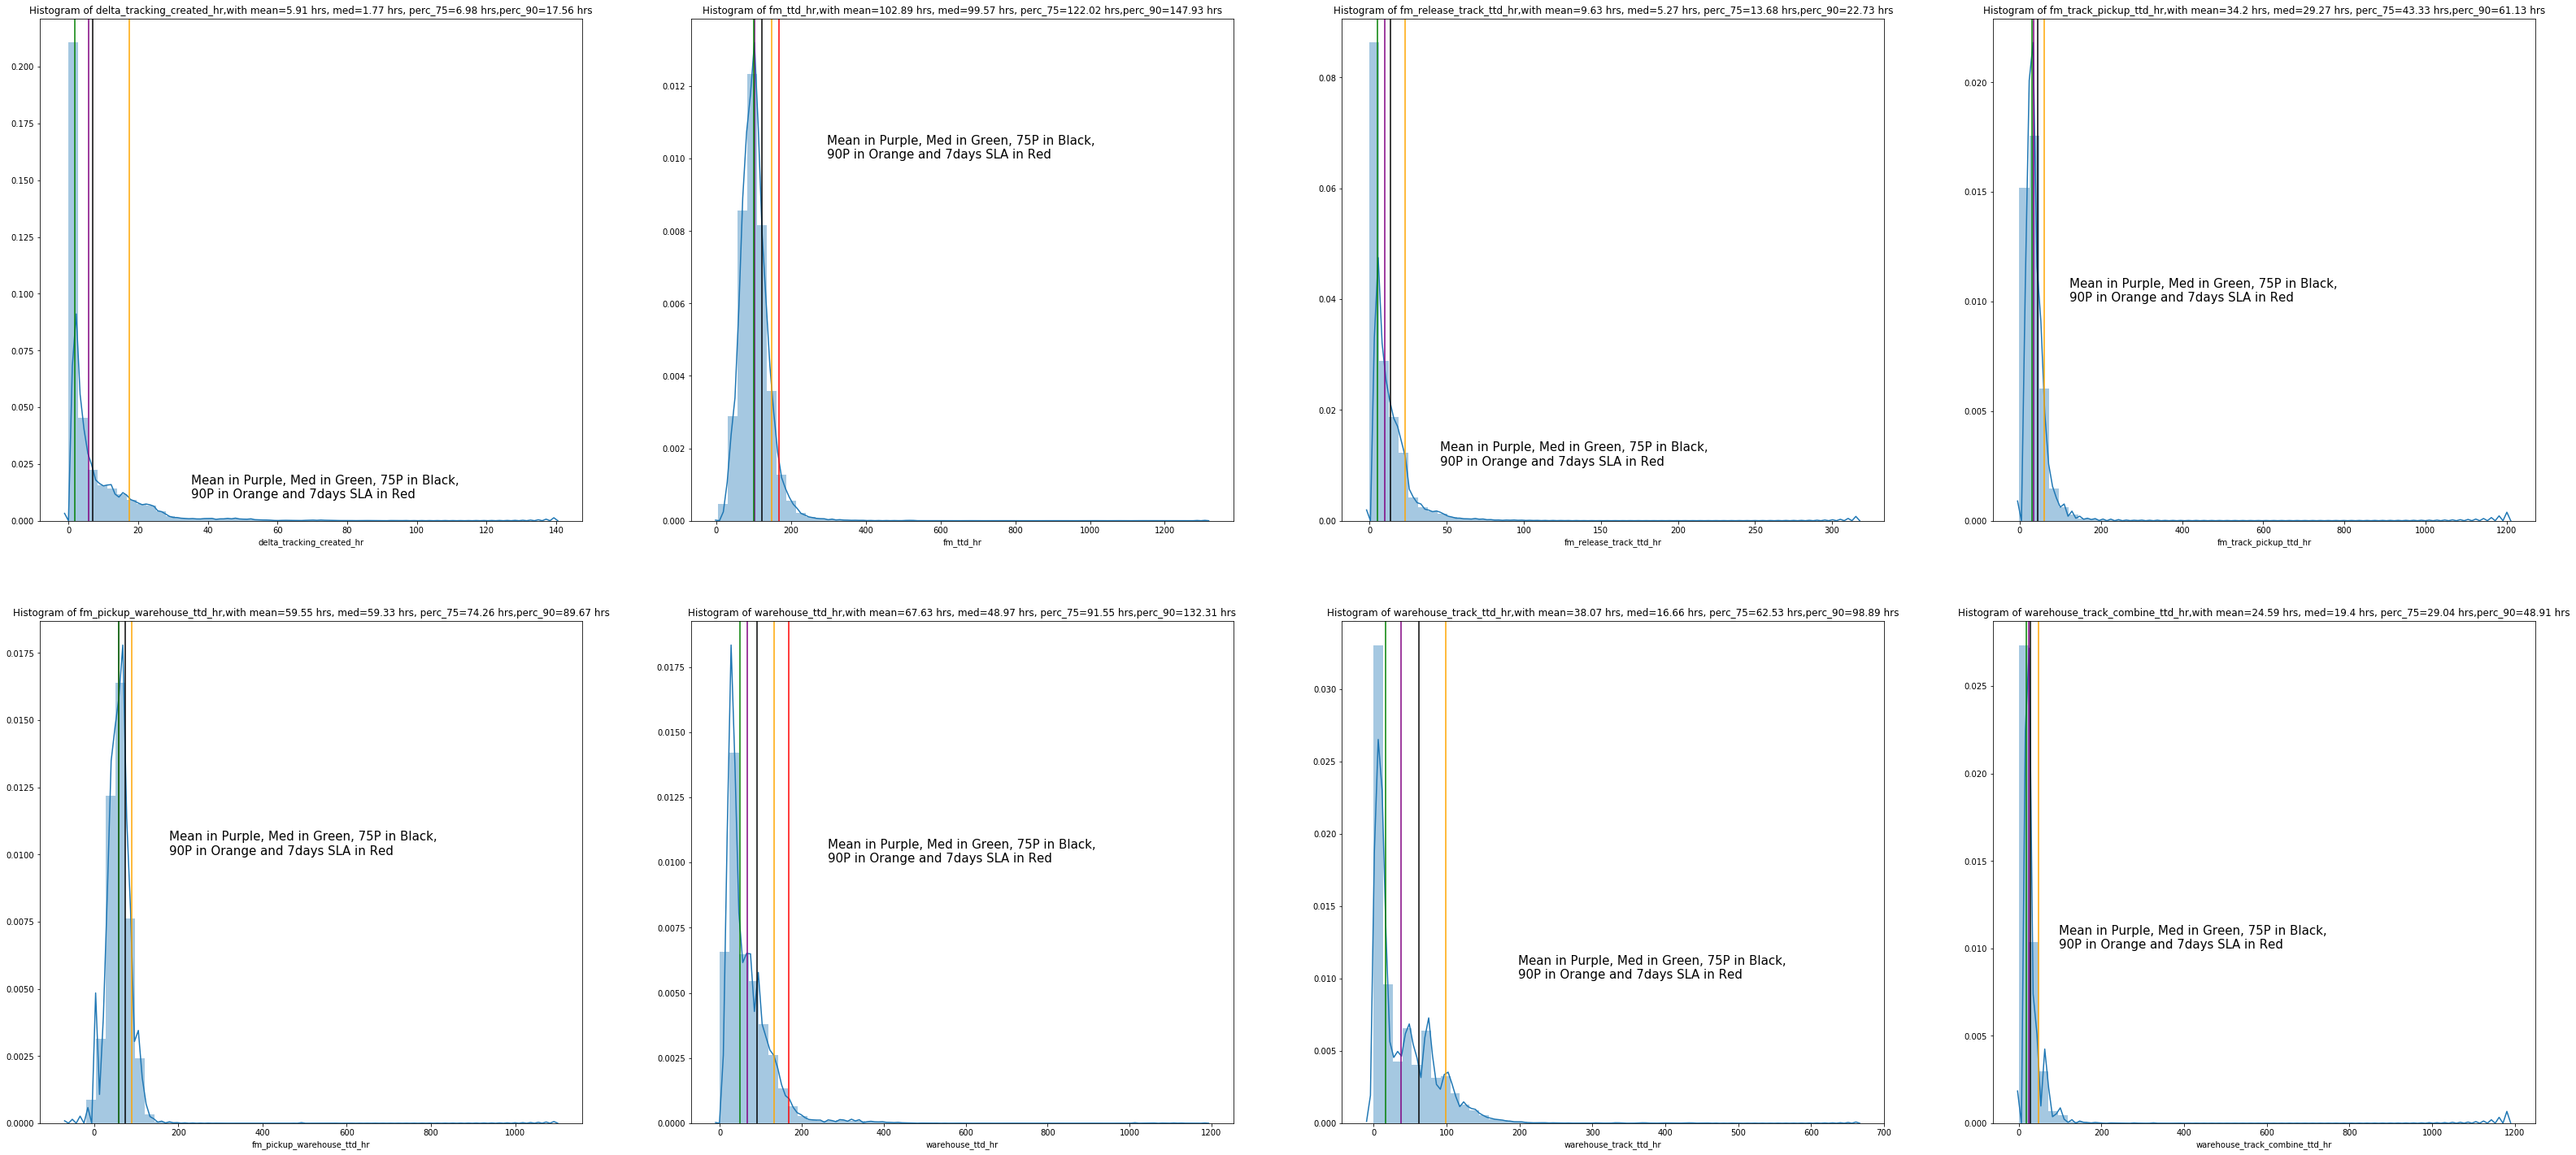

In [20]:

for delivery in delivery_list:
    print('-'*160)
    print('Delivery program is %s' %(delivery))
    print('-'*160)
    fig, axes = plt.subplots(2,4, figsize=(55,25))
    
    for i in range(l):
        m = int(i / 4)
        n = int(i % 4)
        
        mask1 = (df['delivery_program'] == delivery)
        mask2 = (df[checkpoint_list[i]].notnull())
        
        avg = round(df.loc[mask1 & mask2 , checkpoint_list[i]].mean(),2)
        perc_50 = round(df.loc[mask1 & mask2,checkpoint_list[i]].median(),2)
        perc_75= round(df.loc[mask1 & mask2,checkpoint_list[i]].quantile(0.75),2)
        perc_90= round(df.loc[mask1 & mask2,checkpoint_list[i]].quantile(0.9),2)
        
        sns.distplot(df.loc[mask1 & mask2,checkpoint_list[i]], hist=True, kde=True, bins=50, ax=axes[m, n])
        
        axes[m, n].title.set_text('Histogram of %s,with mean=%s hrs, med=%s hrs, perc_75=%s hrs,perc_90=%s hrs' %(checkpoint_list[i],avg,perc_50,perc_75,perc_90))
        axes[m, n].axvline(avg, 0, 1, color='purple')
        axes[m, n].axvline(perc_50, 0, 1, color='green')
        axes[m, n].axvline(perc_75, 0, 1,color='black')
        axes[m, n].axvline(perc_90, 0, 1, color='orange')
        if checkpoint_list[i] in ['fm_ttd_hr','warehouse_ttd_hr']:
            axes[m, n].axvline(7*24, 0, 1, color='red')
        axes[m, n].text(perc_90*2,0.010, 'Mean in Purple, Med in Green, 75P in Black, \n90P in Orange and 7days SLA in Red',size=15)
        
    plt.show()